In [1]:
import torch
import gpytorch
import numpy as np
import optuna
import sys
import os
sys.path.append(os.path.abspath('..'))

from src.plotting import plot_gp, plot_train_test_split
from src.data_loader import PVDataLoader, PVData
from src import data_loader as dl
from src.models import ApproximateGPBaseModel
from src.beta_likelihood import BetaLikelihood_MeanParametrization

In [18]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)

==> Loading data
==> Loaded data in: 0 m : 11 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



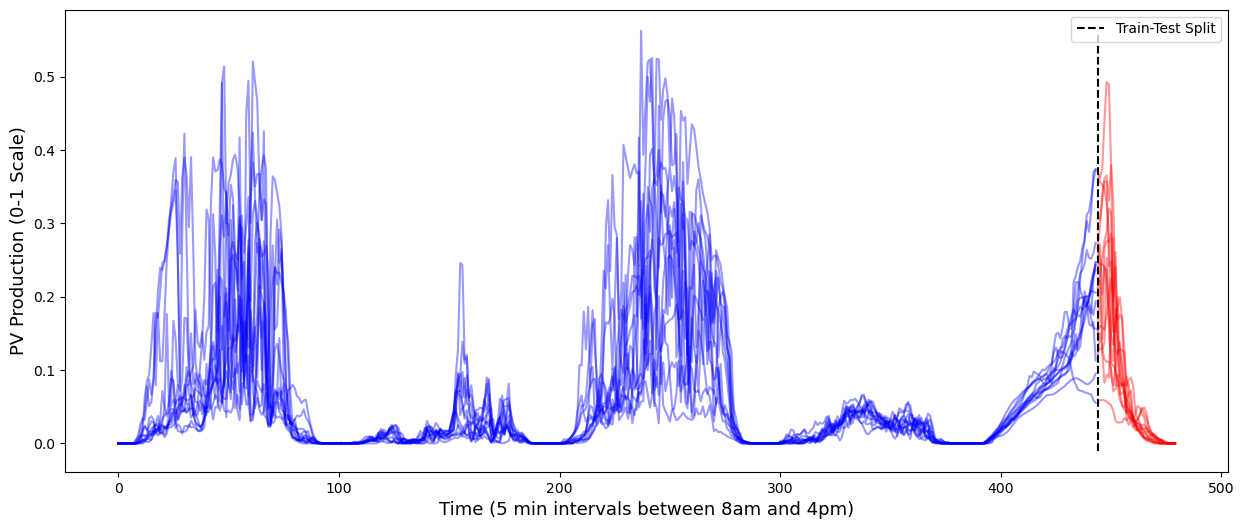

In [22]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

X, y = loader.get_time_series()
x_train, y_train, x_test, y_test = dl.train_test_split(X, y, n_hours=N_HOURS_PRED)
plot_train_test_split(y_train, y_test)

# Stochastic Variational Inference for Gaussian Processes

Limitations:
- stochastic updates which can cause optimization problems and no guarantee of the global optimum is guaranteed, careful initialization and tuning of hyperparameters.
- not exact training data but inducing points (hyperparameter choice)
- not closed form solution for posterior s.t. solution is not exact


Strengths:
- non-gaussian likelihood for flexibility
- scalability
- uncertainty estimation
- approximate inference can capture important aspects of the underlying disitribtuions (giving fairly accurate predictions)

# Kernels

In [23]:
from gpytorch.kernels import (MaternKernel, 
                              PeriodicKernel,
                              ScaleKernel, 
                              AdditiveKernel, 
                              ProductKernel)

matern_base = MaternKernel(nu=3/2, 
                      lengthscale_prior=gpytorch.priors.GammaPrior(2, 8),
                      lengthscale_constraint=gpytorch.constraints.Positive()
                      )
periodic = PeriodicKernel(period_length_prior=gpytorch.priors.GammaPrior(3, 2),
                            period_length_constraint=gpytorch.constraints.Positive()
                        )
scaled_periodic = ScaleKernel(periodic,
                                outputscale_prior=gpytorch.priors.GammaPrior(5, 1),
                                outputscale_constraint=gpytorch.constraints.Positive()
                            )
scaled_matern = ScaleKernel(matern_base, 
                            outputscale_prior=gpytorch.priors.GammaPrior(5, 2),
                            outputscale_constraint=gpytorch.constraints.Interval(0.05, 1)
                            )
product_kernel_matern_periodic = ScaleKernel(periodic * matern_base,
                             outputscale_prior = gpytorch.priors.GammaPrior(5, 2),
                             outputscale_constraint=gpytorch.constraints.Positive()
                            )

quasi_periodic_matern = AdditiveKernel(product_kernel_matern_periodic, scaled_matern)


In [24]:
from gpytorch.kernels import (MaternKernel, 
                              PeriodicKernel,
                              ScaleKernel, 
                              AdditiveKernel)
num_latents = 1

matern_base = MaternKernel(nu=3/2, 
                      batch_shape=torch.Size([num_latents]),
                    lengthscale_prior=gpytorch.priors.GammaPrior(2, 8),
                    lengthscale_constraint=gpytorch.constraints.Positive()
                    )
periodic = PeriodicKernel(  
                    period_length_prior=gpytorch.priors.GammaPrior(3, 2),
                    period_length_constraint=gpytorch.constraints.Positive(),
                    batch_shape=torch.Size([num_latents])
                    )
scaled_periodic = ScaleKernel(
                    periodic,
                    outputscale_prior=gpytorch.priors.GammaPrior(5, 1),
                    outputscale_constraint=gpytorch.constraints.Positive(),
                    batch_shape=torch.Size([num_latents])
                    )
scaled_matern = ScaleKernel(matern_base, 
                    outputscale_prior=gpytorch.priors.GammaPrior(5, 2),
                    outputscale_constraint=gpytorch.constraints.Interval(0.01, 1),
                    batch_shape=torch.Size([num_latents])
                    )
matern_periodic = ScaleKernel(periodic * matern_base,
                    outputscale_prior = gpytorch.priors.GammaPrior(5, 2),
                    outputscale_constraint=gpytorch.constraints.Positive(),
                    batch_shape=torch.Size([num_latents])
                    )

quasi_periodic_matern = AdditiveKernel(matern_periodic, scaled_matern)

Iter 30/300 - Loss: -3.711
Iter 60/300 - Loss: -4.177
Iter 90/300 - Loss: -4.354
Iter 120/300 - Loss: -4.459
Iter 150/300 - Loss: -4.523
Iter 180/300 - Loss: -4.563
Iter 210/300 - Loss: -4.587
Iter 240/300 - Loss: -4.602
Iter 270/300 - Loss: -4.613
Iter 300/300 - Loss: -4.620


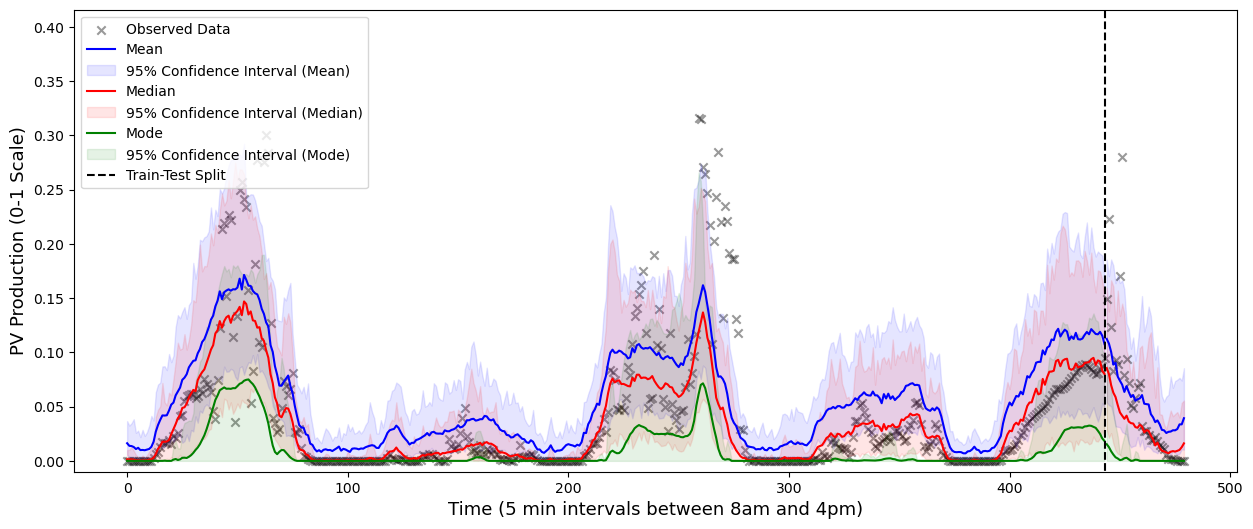

Iter 30/300 - Loss: -3.094
Iter 60/300 - Loss: -3.602
Iter 90/300 - Loss: -3.724
Iter 120/300 - Loss: -3.788
Iter 150/300 - Loss: -3.825
Iter 180/300 - Loss: -3.847
Iter 210/300 - Loss: -3.862
Iter 240/300 - Loss: -3.874
Iter 270/300 - Loss: -3.884
Iter 300/300 - Loss: -3.893


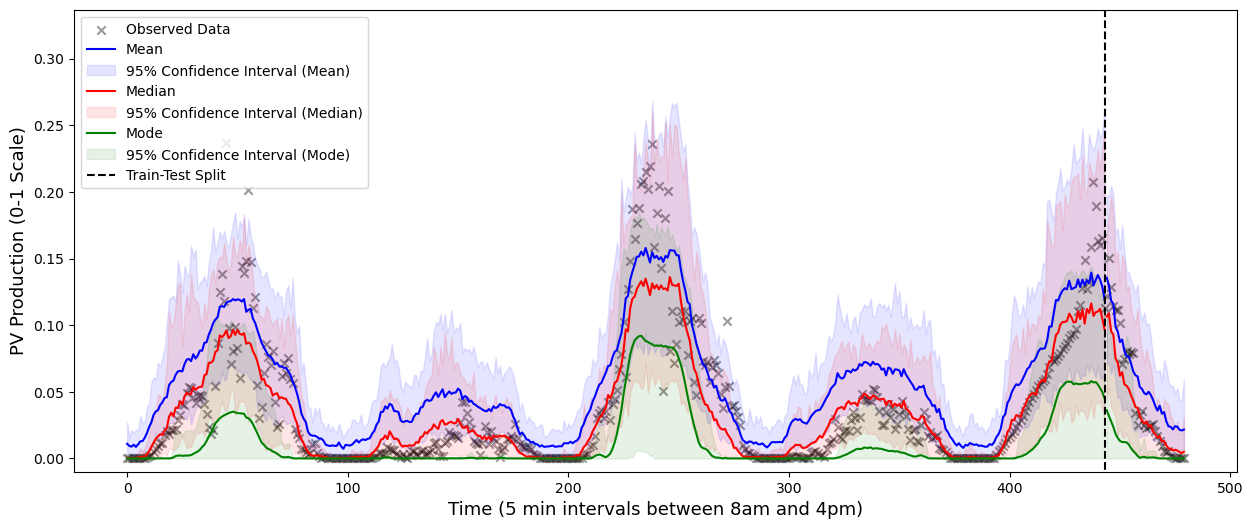

Iter 30/300 - Loss: -2.969
Iter 60/300 - Loss: -3.342
Iter 90/300 - Loss: -3.500
Iter 120/300 - Loss: -3.578
Iter 150/300 - Loss: -3.621
Iter 180/300 - Loss: -3.647
Iter 210/300 - Loss: -3.664
Iter 240/300 - Loss: -3.676
Iter 270/300 - Loss: -3.686
Iter 300/300 - Loss: -3.695


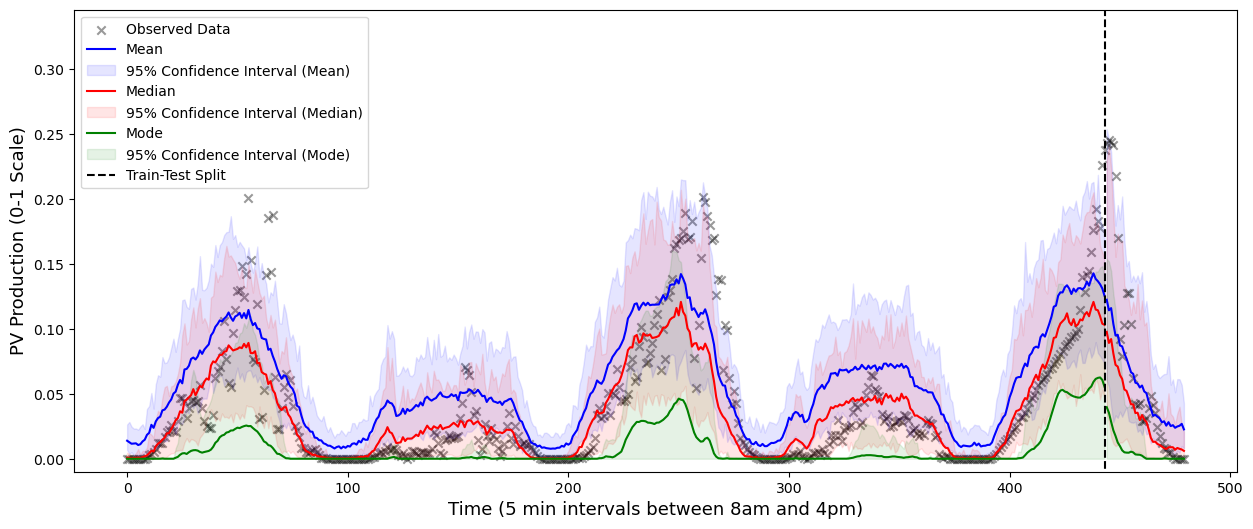

Iter 30/300 - Loss: -2.842
Iter 60/300 - Loss: -3.337
Iter 90/300 - Loss: -3.465
Iter 120/300 - Loss: -3.518
Iter 150/300 - Loss: -3.547
Iter 180/300 - Loss: -3.564
Iter 210/300 - Loss: -3.577
Iter 240/300 - Loss: -3.587
Iter 270/300 - Loss: -3.595
Iter 300/300 - Loss: -3.601


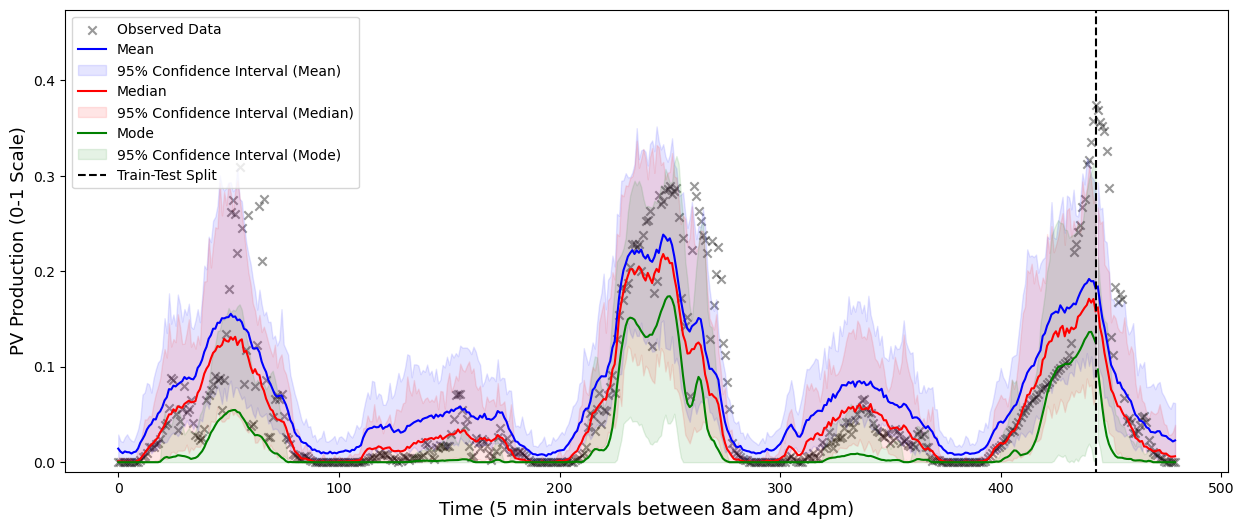

Iter 30/300 - Loss: -2.578
Iter 60/300 - Loss: -3.111
Iter 90/300 - Loss: -3.271
Iter 120/300 - Loss: -3.339
Iter 150/300 - Loss: -3.371
Iter 180/300 - Loss: -3.388
Iter 210/300 - Loss: -3.399
Iter 240/300 - Loss: -3.407
Iter 270/300 - Loss: -3.413
Iter 300/300 - Loss: -3.419


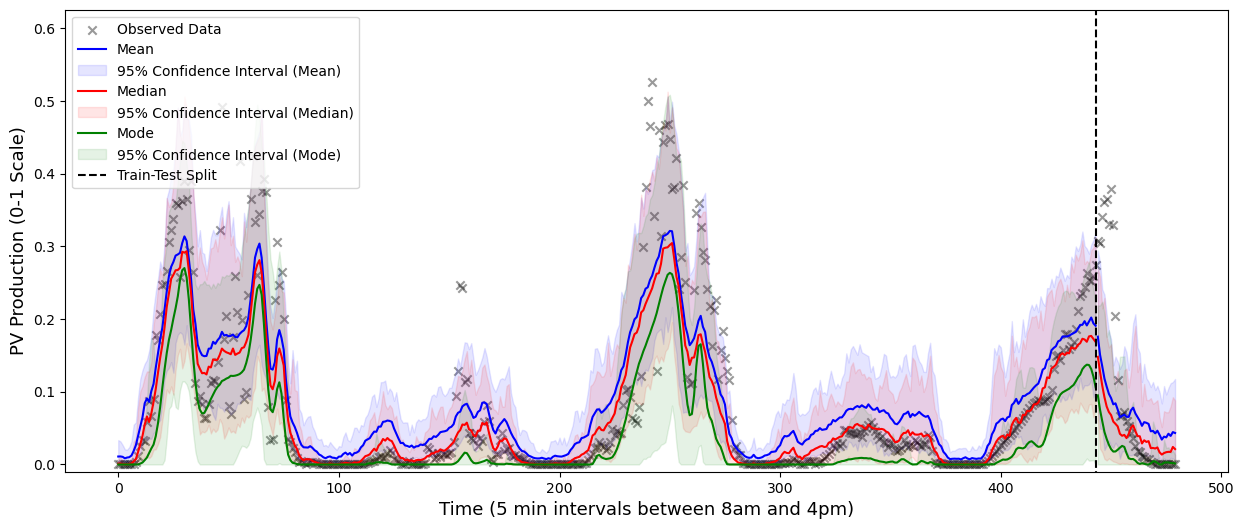

Iter 30/300 - Loss: -2.724
Iter 60/300 - Loss: -3.193
Iter 90/300 - Loss: -3.360
Iter 120/300 - Loss: -3.427
Iter 150/300 - Loss: -3.462
Iter 180/300 - Loss: -3.485
Iter 210/300 - Loss: -3.501
Iter 240/300 - Loss: -3.514
Iter 270/300 - Loss: -3.525
Iter 300/300 - Loss: -3.535


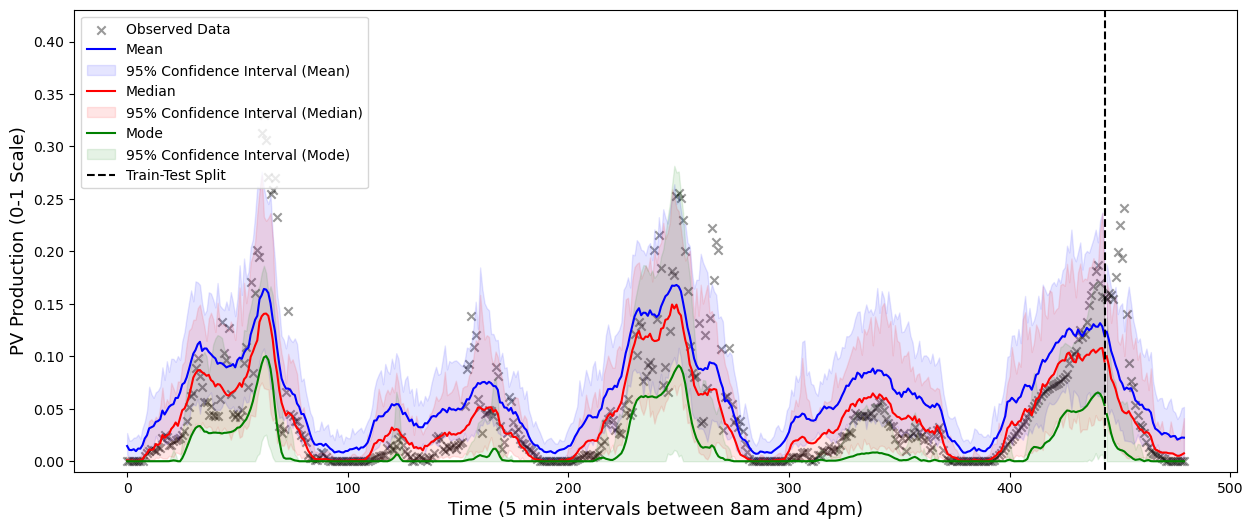

Iter 30/300 - Loss: -2.550
Iter 60/300 - Loss: -3.036
Iter 90/300 - Loss: -3.188
Iter 120/300 - Loss: -3.250
Iter 150/300 - Loss: -3.280
Iter 180/300 - Loss: -3.299
Iter 210/300 - Loss: -3.313
Iter 240/300 - Loss: -3.324
Iter 270/300 - Loss: -3.333
Iter 300/300 - Loss: -3.341


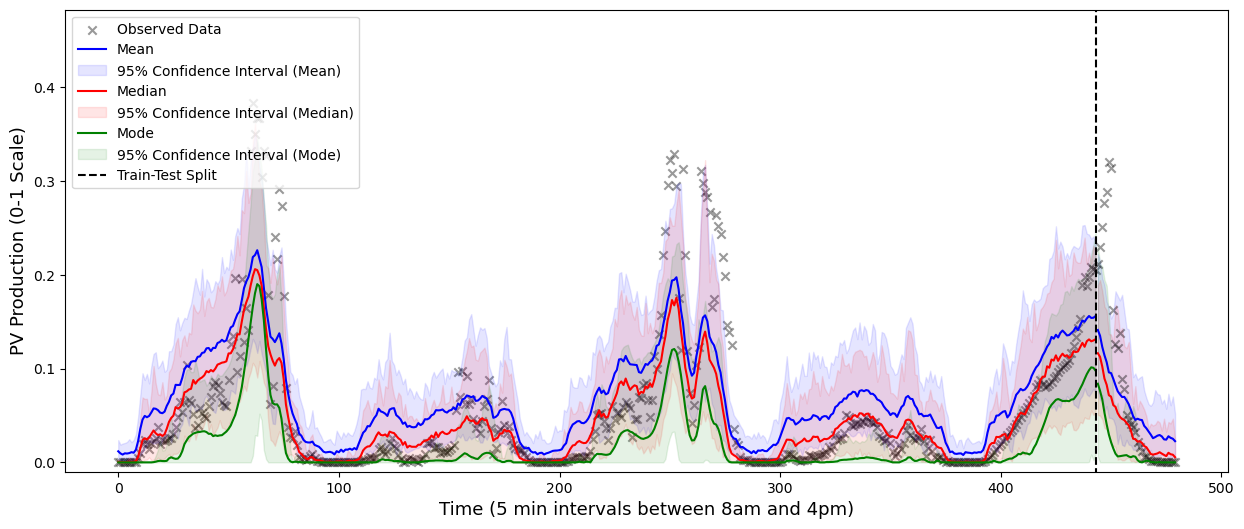

Iter 30/300 - Loss: -2.281
Iter 60/300 - Loss: -2.835
Iter 90/300 - Loss: -3.092
Iter 120/300 - Loss: -3.182
Iter 150/300 - Loss: -3.214
Iter 180/300 - Loss: -3.231
Iter 210/300 - Loss: -3.241
Iter 240/300 - Loss: -3.247
Iter 270/300 - Loss: -3.252
Iter 300/300 - Loss: -3.255


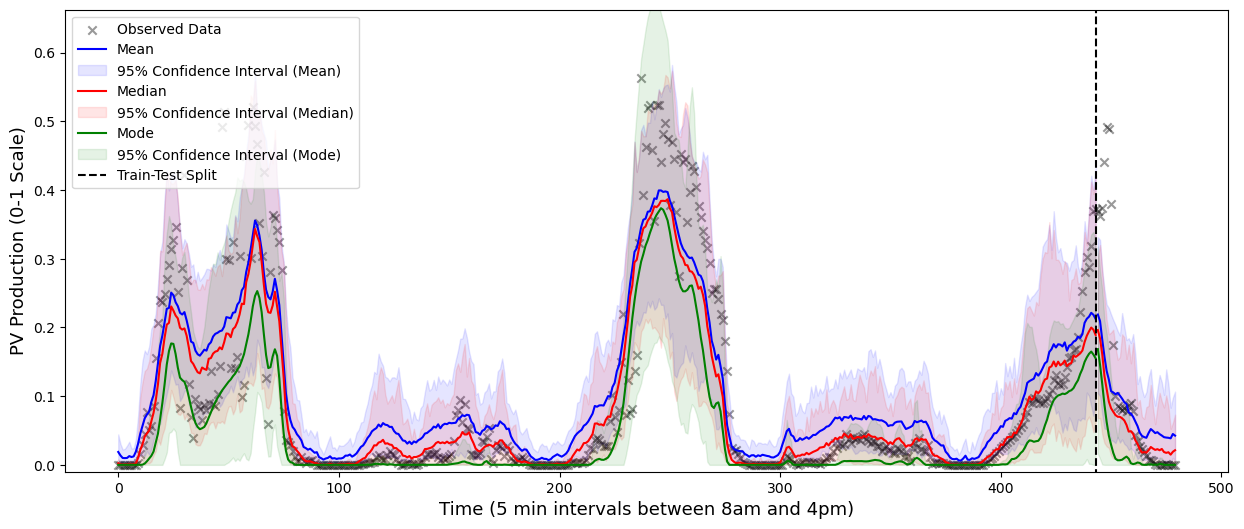

Iter 30/300 - Loss: -2.558
Iter 60/300 - Loss: -2.981
Iter 90/300 - Loss: -3.108
Iter 120/300 - Loss: -3.165
Iter 150/300 - Loss: -3.195
Iter 180/300 - Loss: -3.212
Iter 210/300 - Loss: -3.223
Iter 240/300 - Loss: -3.232
Iter 270/300 - Loss: -3.241
Iter 300/300 - Loss: -3.249


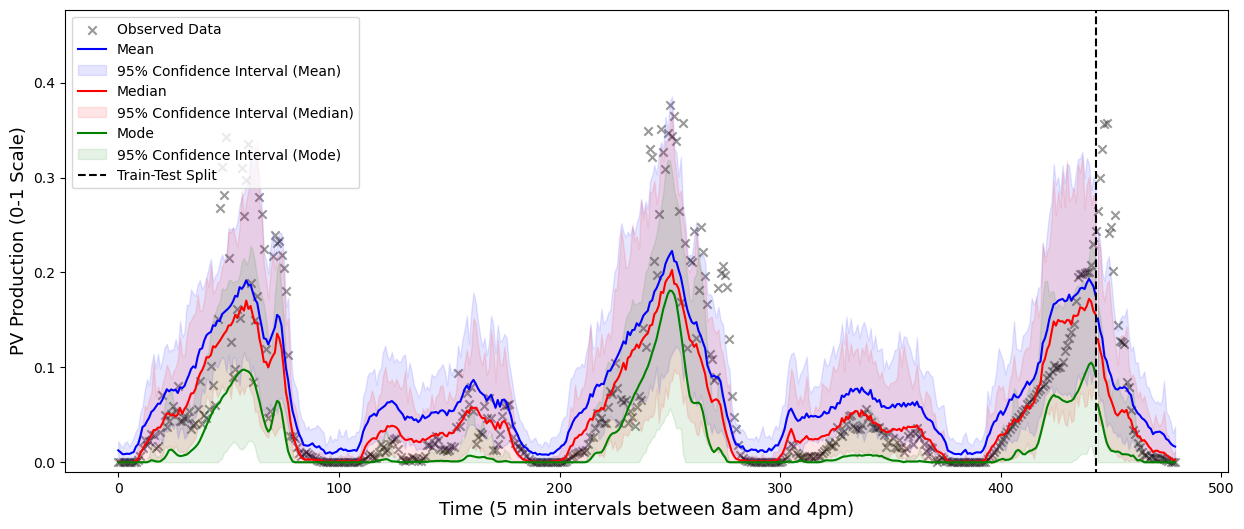

Iter 30/300 - Loss: -2.799
Iter 60/300 - Loss: -3.246
Iter 90/300 - Loss: -3.431
Iter 120/300 - Loss: -3.505
Iter 150/300 - Loss: -3.540
Iter 180/300 - Loss: -3.559
Iter 210/300 - Loss: -3.572
Iter 240/300 - Loss: -3.581
Iter 270/300 - Loss: -3.588
Iter 300/300 - Loss: -3.595


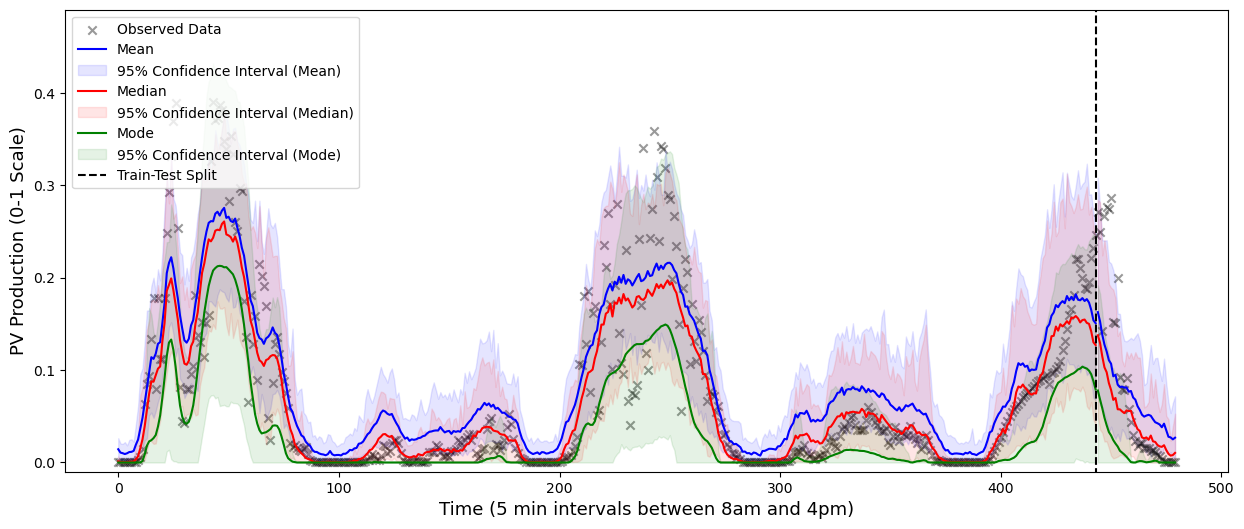

Iter 30/300 - Loss: -2.791
Iter 60/300 - Loss: -3.210
Iter 90/300 - Loss: -3.350
Iter 120/300 - Loss: -3.412
Iter 150/300 - Loss: -3.441
Iter 180/300 - Loss: -3.458
Iter 210/300 - Loss: -3.470
Iter 240/300 - Loss: -3.478
Iter 270/300 - Loss: -3.486
Iter 300/300 - Loss: -3.492


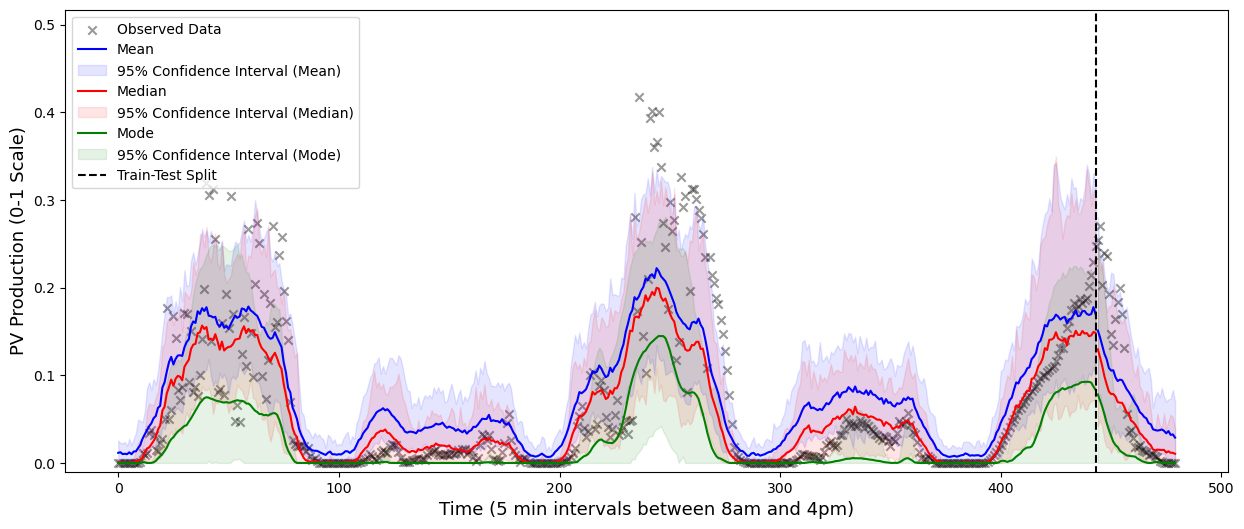

Iter 30/300 - Loss: -2.608
Iter 60/300 - Loss: -3.069
Iter 90/300 - Loss: -3.213
Iter 120/300 - Loss: -3.277
Iter 150/300 - Loss: -3.310
Iter 180/300 - Loss: -3.330
Iter 210/300 - Loss: -3.343
Iter 240/300 - Loss: -3.354
Iter 270/300 - Loss: -3.363
Iter 300/300 - Loss: -3.372


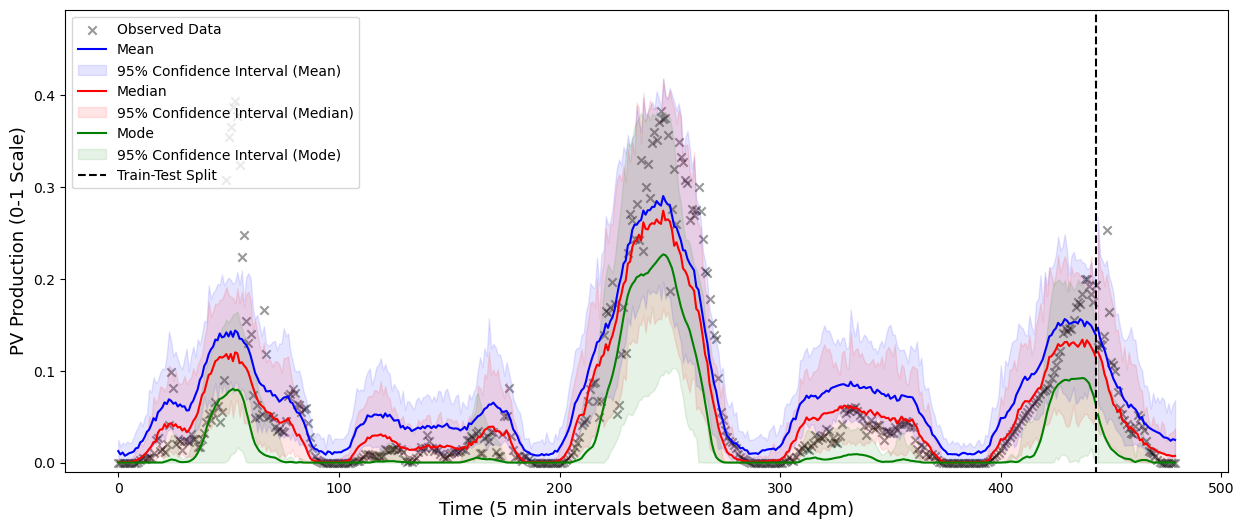

Iter 30/300 - Loss: -3.001
Iter 60/300 - Loss: -3.531
Iter 90/300 - Loss: -3.680
Iter 120/300 - Loss: -3.753
Iter 150/300 - Loss: -3.792
Iter 180/300 - Loss: -3.816
Iter 210/300 - Loss: -3.832
Iter 240/300 - Loss: -3.845
Iter 270/300 - Loss: -3.855
Iter 300/300 - Loss: -3.864


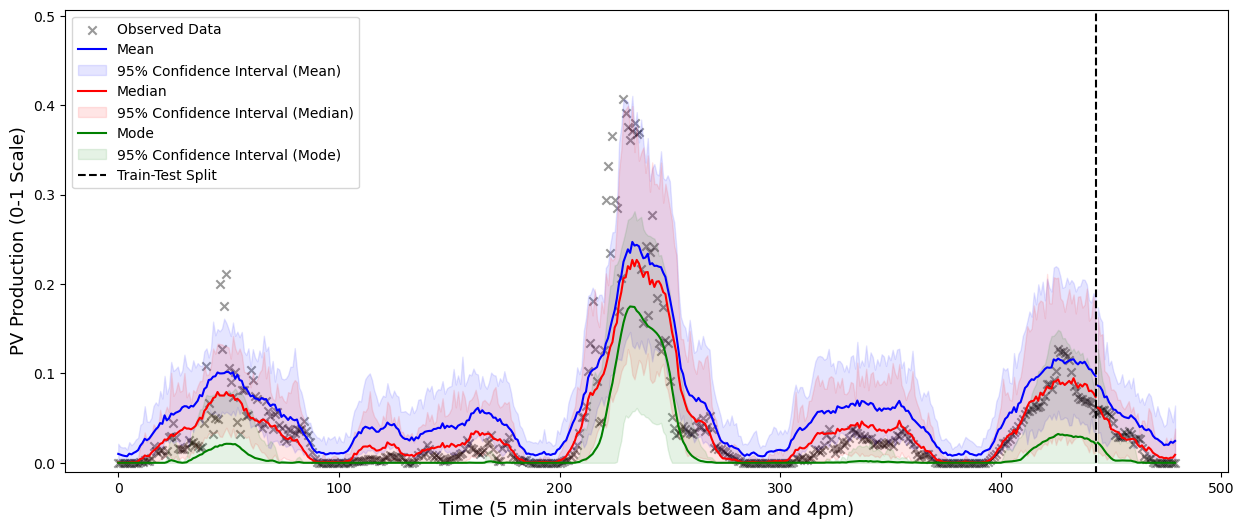

In [28]:
jitter = 1e-4
config = {  'type': 'stochastic',
            'name': 'mean_field',
            'num_inducing_points': x_train.size(0),
            'mean_init_std': 1,
            }

for idx in range(y_train.size(1)):
    
  
    inputs_mean = { 'X': x_train, 
                    'y': y_train[:, idx], 
                    'mean_module': gpytorch.means.ConstantMean(),
                    'covar_module': quasi_periodic_matern,
                    'likelihood': BetaLikelihood_MeanParametrization(scale=10,
                                                                     correcting_scale=1,
                                                                     lower_bound=0.10,
                                                                     upper_bound=0.80),
                    'config': config,
                    'jitter': jitter
                }

    model_beta = ApproximateGPBaseModel(**inputs_mean)
    model_beta.fit(n_iter=300, lr=0.1,  verbose=True)    
    
    preds = model_beta.predict(X)
    plot_gp(model_beta, x_train, x_test, y_train[:,idx], y_test[:,idx], pred_type='all')


# Hyperparameter Optimization

In [8]:
config = {'type': 'stochastic',
            'name': 'mean_field',
            'num_inducing_points': x_train.size(0),
            'mean_init_std': 1,
            }

jitter = 1e-4

hyper_opt = HyperParameterOptimization( model='beta',
                                        x_train=x_train,
                                        y_train=y_train,
                                        x_test=x_test,
                                        y_test=y_test,
)
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: hyper_opt.objective(trial, config, jitter, kernel='matern'), n_trials=10)

[I 2023-06-28 15:49:26,222] A new study created in memory with name: no-name-bddeaeaf-a966-4f94-ab59-4a13fb380c66
/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 30] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 26].
  warnings.warn(
[I 2023-06-28 15:52:11,973] Trial 0 finished with value: 0.044488128274679184 and parameters: {'matern_L_shape': 2.0, 'matern_L_rate': 6.0, 'signal_matern_shape': 7.0, 'signal_matern_rate': 9.0, 'likelihood_scale': 16, 'likelihood_correcting_scale': 3.0, 'lr': 0.30000000000000004}. Best is trial 0 with value: 0.044488128274679184.
[I 2023-06-28 15:54:52,988] Trial 1 finished with value: 0.04648548364639282 and parameters: {'matern_L_shape': 1.0, 'matern_L_rate': 3.0, 'signal_matern_shape': 2.0, 'signal_matern_rate': 7.0, 'likelihood_scale': 26, 'likelihood_correcting_scale': 3.0, 'lr': 0.1}. Best is trial 0 with value:

In [8]:
from optuna.visualization import plot_optimization_history, plot_contour, plot_parallel_coordinate, plot_param_importances

In [9]:
plot_optimization_history(study)

In [12]:
plot_contour(study, params=[ 'period_P_shape', 'period__P_rate'])

In [13]:
plot_parallel_coordinate(study)

In [14]:
plot_param_importances(study)

In [15]:
best_params = study.best_params
best_params

{'matern_L_shape': 5.0,
 'matern_L_rate': 4.0,
 'signal_matern_shape': 7.0,
 'signal_matern_rate': 5.0,
 'periodic_L_shape': 5.0,
 'period_L_rate': 2.0,
 'period_P_shape': 5.0,
 'period__P_rate': 2.0,
 'signal_periodic_shape': 9.0,
 'signal_periodic_rate': 1.0,
 'likelihood_scale': 16,
 'likelihood_correcting_scale': 1.0,
 'lr': 0.1}